In [43]:
import pandas as pd
import numpy as np
from py_geohash_any import geohash as gh
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Data Dictionary : Yellow Taxi Cab
- VendorID A code indicating the TPEP provider that provided the record.
1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.
- tpep_pickup_datetime The date and time when the meter was engaged.
- tpep_dropoff_datetime The date and time when the meter was disengaged.
- Passenger_count The number of passengers in the vehicle.
 This is a driver-entered value.
- Trip_distance The elapsed trip distance in miles reported by the taximeter.
- Pickup_longitude Longitude where the meter was engaged.
- Pickup_latitude Latitude where the meter was engaged.
- RateCodeID The final rate code in effect at the end of the trip.
 1= Standard rate 
 2=JFK
 3=Newark
 4=Nassau or Westchester
 5=Negotiated fare
 6=Group ride
- Store_and_fwd_flag This flag indicates whether the trip record was held in vehicle
 memory before sending to the vendor, aka “store and forward,”
 because the vehicle did not have a connection to the server.
- Y= store and forward trip
- N= not a store and forward trip
- Dropoff_longitude Longitude where the meter was disengaged.
- Dropoff_ latitude Latitude where the meter was disengaged.
- Payment_type A numeric code signifying how the passenger paid for the trip.
 1= Credit card
 2= Cash
 3= No charge
 4= Dispute
 5= Unknown
 6= Voided trip
- Fare_amount The time-and-distance fare calculated by the meter.
- Extra Miscellaneous extras and surcharges. Currently, this only includes
 t he 0.50 and 1 rush hour and overnight charges.
 M TA_tax 0.50 MTA tax that is automatically triggered based on the metered
 rate in use.
- Improvement_surcharge 0.30 improvement surcharge assessed trips at the flag drop. The
- improvement surcharge began being levied in 2015.
- Tip_amount Tip amount – This field is automatically populated for credit card
 tips. Cash tips are not included.
- Tolls_amount Total amount of all tolls paid in trip.
- Total_amount The total amount charged to passengers. Does not include cash tips.

### Geohash dictionary the distance between geohashes based on matching characters, in meters.
_PRECISION = {
    0: 20000000,
    1: 5003530,
    2: 625441,
    3: 123264,
    4: 19545,
    5: 3803,
    6: 610,
    7: 118,
    8: 19,
    9: 3.71,
    10: 0.6,
}

### Average speed of taxis
- In 2014, it dropped to 8.51 MPH. http://www.wnyc.org/story/traffic-speeds-slow-nyc-wants-curb-car-service-growth/
- 8.51 MPH is 3.80431 meters / second

### Geohash units are meters
- http://stackoverflow.com/questions/13448595/geohash-string-length-and-accuracy

In [4]:
#yellow_taxi_geohash_min_day
taxi_yellowcab_df = pd.read_csv("data/yellow_taxi_geohash_min_day.csv"")

In [24]:
# Encoding error
taxi_yellowcab_df['geohash_dropoff']=taxi_yellowcab_df['geohas_dropoff']

In [5]:
taxi_lookup = pd.read_csv("data/taxi+_zone_lookup.csv")

In [6]:
names_ = ['zipcode','city','state','lat','long','radius?','?']
#dataframe = read_csv('projects.csv', converters={'project_id': lambda x: str(x)})
zip_codes = pd.read_csv("data/zipcode.csv",converters={'zipcode': lambda x: str(x)},names=names_)

In [7]:
zip_codes .head()

,zipcode,city,state,lat,long,radius?,?
0,00210,Portsmouth,NH,43.005895,-71.013202,-5,1
1,00211,Portsmouth,NH,43.005895,-71.013202,-5,1
2,00212,Portsmouth,NH,43.005895,-71.013202,-5,1
3,00213,Portsmouth,NH,43.005895,-71.013202,-5,1
4,00214,Portsmouth,NH,43.005895,-71.013202,-5,1


In [8]:
taxi_lookup.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [9]:
zip_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43191 entries, 0 to 43190
Data columns (total 7 columns):
zipcode    43191 non-null object
city       43191 non-null object
state      43191 non-null object
lat        43191 non-null float64
long       43191 non-null float64
radius?    43191 non-null int64
?          43191 non-null int64
dtypes: float64(2), int64(2), object(3)
memory usage: 2.3+ MB


In [10]:
# Truncate zip codes to only be NY

In [11]:
zip_codes_ny = zip_codes[zip_codes.state=='NY']

In [12]:
zip_codes_ny.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2281 entries, 6 to 5721
Data columns (total 7 columns):
zipcode    2281 non-null object
city       2281 non-null object
state      2281 non-null object
lat        2281 non-null float64
long       2281 non-null float64
radius?    2281 non-null int64
?          2281 non-null int64
dtypes: float64(2), int64(2), object(3)
memory usage: 142.6+ KB


In [13]:
taxi_yellowcab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10906858 entries, 0 to 10906857
Data columns (total 22 columns):
Unnamed: 0               int64
VendorID                 int64
tpep_pickup_datetime     object
tpep_dropoff_datetime    object
passenger_count          int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID               int64
store_and_fwd_flag       object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
geohash_pickup           object
geohas_dropoff           object
dtypes: float64(12), int64(5), object(5)
memory usage: 1.8+ GB


In [14]:
taxi_yellowcab_df.head(10)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,geohash_pickup,geohas_dropoff
0,0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,...,2,7.5,0.5,0.5,0.0,0.0,0.3,8.8,dr5rsr,dr5rsx
1,1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,...,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3,dr5rsw,dr5rtk
2,2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,...,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3,dr5rkm,dr72j1
3,3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,...,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3,dr5rsh,dr5rkc
4,4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,...,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8,dr72hb,dr5rue
5,5,2,2016-01-01 00:00:00,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,1,N,...,2,19.0,0.5,0.5,0.0,0.0,0.3,20.3,dr5ru9,dr5ryh
6,6,2,2016-01-01 00:00:00,2016-01-01 00:26:45,2,7.45,-73.994057,40.719990,1,N,...,2,26.0,0.5,0.5,0.0,0.0,0.3,27.3,dr5rsh,dr72hc
7,7,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.20,-73.979424,40.744614,1,N,...,2,9.0,0.5,0.5,0.0,0.0,0.3,10.3,dr5ru9,dr5ru7
8,8,1,2016-01-01 00:00:02,2016-01-01 00:11:14,1,6.00,-73.947151,40.791046,1,N,...,2,18.0,0.5,0.5,0.0,0.0,0.3,19.3,dr72j3,dr72mz
9,9,2,2016-01-01 00:00:02,2016-01-01 00:11:08,1,3.21,-73.998344,40.723896,1,N,...,2,11.5,0.5,0.5,0.0,0.0,0.3,12.8,dr5rsj,dr5rkp


In [15]:
from datetime import datetime, timedelta, date
import dateutil
st_date = '2016-11-01'
dt = dateutil.parser.parse(st_date).date()
dt

datetime.date(2016, 11, 1)

## Create new columns for the day, and minute of january
- Don't run again, save this as csv

In [16]:
#taxi_yellowcab_df['jan_day']=[dateutil.parser.parse(i).day for i in taxi_yellowcab_df.tpep_dropoff_datetime]

In [17]:
#taxi_yellowcab_df['jan_minute']=[dateutil.parser.parse(i).minute for i in taxi_yellowcab_df.tpep_dropoff_datetime]

In [18]:
#taxi_yellowcab_df.to_csv("data/yellow_taxi_geohash_min_day.csv")

In [19]:
taxi_yellowcab_df.tail()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,geohash_pickup,geohas_dropoff,jan_day,jan_minute
10906853,10906853,2,2016-01-31 23:30:32,2016-01-31 23:38:18,1,2.2,-74.003578,40.751011,1,N,...,0.5,0.5,0.00,0.00,0.3,9.80,dr5ru4,dr5rum,31,38
10906854,10906854,1,2016-01-05 00:15:55,2016-01-05 00:16:06,1,0.0,-73.945488,40.751530,1,N,...,0.5,0.5,0.00,0.00,0.3,3.80,dr5rv6,dr5rv6,5,16
10906855,10906855,1,2016-01-05 06:12:46,2016-03-19 20:45:50,3,1.4,-73.994240,40.766586,1,N,...,0.5,0.5,0.00,0.00,0.3,8.80,dr5ruj,dr5ru7,19,45
10906856,10906856,1,2016-01-05 06:21:44,2016-03-28 12:54:26,1,2.1,-73.948067,40.776531,1,N,...,0.0,0.5,2.45,0.00,0.3,14.75,dr5rvr,dr5rux,28,54
10906857,10906857,1,2016-01-05 06:15:21,2016-01-05 06:15:36,3,0.0,-73.960938,40.758595,2,N,...,0.0,0.5,0.00,5.54,0.3,58.34,dr5rug,dr5rug,5,15


In [170]:
taxi_yellowcab_df[taxi_yellowcab_df.VendorID==2].head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,jan_day,jan_minute
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,...,2,7.5,0.5,0.5,0.0,0.0,0.3,8.8,1,0
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,...,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3,1,0
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,...,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3,1,0
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,...,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3,1,0
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,...,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8,1,0


- Transform lat and long to zip code

>zip_code_data from: https://github.com/EverythingMe/geodis


In [112]:
taxi_sample = taxi_yellowcab_df.sample(10000)

In [27]:
zip_codes_ny.head()

,zipcode,city,state,lat,long,radius?,?
6,00501,Holtsville,NY,40.922326,-72.637078,-5,1
7,00544,Holtsville,NY,40.922326,-72.637078,-5,1
2446,06390,Fishers Island,NY,41.261936,-72.007080,-5,1
3443,10001,New York,NY,40.750742,-73.996530,-5,1
3444,10002,New York,NY,40.717040,-73.987000,-5,1


In [71]:
taxi_sample.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
248133,2,2016-01-01 13:57:29,2016-01-01 14:10:50,1,2.64,-73.991890,40.749260,1,N,-73.982674,40.723141,1,12.0,0.0,0.5,2.56,0.0,0.3,15.36
10346448,2,2016-01-08 13:36:25,2016-01-08 13:42:44,1,0.75,-73.986359,40.755230,1,N,-73.985291,40.752110,2,6.0,0.0,0.5,0.00,0.0,0.3,6.80
6177573,2,2016-01-15 08:52:53,2016-01-15 09:00:29,5,1.32,-73.986053,40.734699,1,N,-73.978767,40.750702,1,7.5,0.0,0.5,1.66,0.0,0.3,9.96
2612091,2,2016-01-16 09:56:47,2016-01-16 10:04:13,1,1.05,-73.954895,40.767284,1,N,-73.968422,40.765030,1,7.0,0.0,0.5,1.17,0.0,0.3,8.97
8041976,1,2016-01-31 23:59:05,2016-02-01 00:06:01,1,0.70,-73.981216,40.755569,1,N,-73.969368,40.752079,1,6.0,0.5,0.5,1.45,0.0,0.3,8.75


### Create a geohash of the latitude and longtitude of the pickup and dropoff

In [123]:
def geohash_encoding(taxi_df,precision_=6):
    """Encode the latitude and longtitude of the pickup and dropoff into a geohash. For reference, the precision
    of a geohash depends on the number of characters present.
    _PRECISION = { 0: 20000000, 1: 5003530, 2: 625441, 3: 123264, 4: 19545,
    5: 3803, 6: 610, 7: 118, 8: 19, 9: 3.71, 10: 0.6, } - all distances in meters.
    
    Average taxi speed in 2014 was 5.51 miles per hour, or 3.8 meters per second.
    Precision of 5, means that a taxi should traverse this square in ~16 minutes.
    Precision of 6, means a taxi should traverse square in ~3 minutes.
    Precision of 7, means a taxi should traverse the square in ~1 minute.
    
    Input: Pandas DF
    Output: Pandas DF with geohas column appended"""
    now = time.time()
    new_taxidf = taxi_df.copy()
    geo_hash_pickup = []
    geo_hash_dropoff = []
    for row in new_taxidf.iterrows():
        # longittude followed by latitude
        pickup_vector = np.array( [row[1]['pickup_latitude'],row[1]['pickup_longitude']])
        dropoff_vector = np.array( [row[1]['dropoff_latitude'],row[1]['dropoff_longitude']])
        #geohash encoding
        geo_hash_pickup.append(gh.encode(pickup_vector[0],pickup_vector[1],precision=precision_))
        geo_hash_dropoff.append(gh.encode(dropoff_vector[0],dropoff_vector[1],precision=precision_))
    ## add in the new geohash columns
    new_taxidf['geohash_pickup'] = geo_hash_pickup
    new_taxidf['geohash_dropoff'] = geo_hash_dropoff 
    return new_taxidf
        
    
    

> Time how long this will take to run for 10 million rows
- 1k samples takes .297 seconds
- 10k samples takes 2.34 seconds
- 10 million rows is 1,000x 10k so 2340 seconds or 39 minutes

In [117]:
# Already ran this
#taxi_yellowcab_jan_geohash_df = geohash_encoding(taxi_yellowcab_df)

In [127]:
taxi_yellowcab_jan_geohash_df = taxi_yellowcab_jan_geohash_df[0]

In [128]:
taxi_yellowcab_jan_geohash_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,geohash_pickup,geohas_dropoff
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,...,2,7.5,0.5,0.5,0.0,0.0,0.3,8.8,dr5rsr,dr5rsx
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,...,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3,dr5rsw,dr5rtk
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,...,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3,dr5rkm,dr72j1
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,...,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3,dr5rsh,dr5rkc
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,...,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8,dr72hb,dr5rue


In [129]:
# save the geohashes
#taxi_yellowcab_jan_geohash_df.to_csv('yellow_taxi_geohash_jan_df.csv')

# Finding neighbors from a dropoff geohash
- use gh.neighbors

In [141]:
gh.neighbors(taxi_yellowcab_jan_geohash_df.geohas_dropoff[0])

{'e': 'dr5rsz',
 'n': 'dr5rs0',
 'ne': 'dr5rs2',
 'nw': 'dr5rse',
 's': 'dr5rsw',
 'se': 'dr5rsy',
 'sw': 'dr5rsa',
 'w': 'dr5rsb'}

## Heat map of the most profitable zip codes 

In [20]:
taxi_yellowcab_df.columns

Index(['Unnamed: 0', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'geohash_pickup', 'geohas_dropoff', 'jan_day', 'jan_minute'],
      dtype='object')

In [63]:
dropoff_sum_fare = taxi_yellowcab_df.groupby('geohash_dropoff').sum()['total_amount'].reset_index()


In [64]:
dropoff_sum_fare = dropoff_sum_fare.sort_values(by='total_amount',ascending=False)

In [65]:
dropoff_sum_fare['total_amount']= dropoff_sum_fare.total_amount.apply(lambda x: round(x))

In [ ]:
# can only plot 2k values on google maps

In [69]:
dropoff_sum_fare.loc[:2000,:].to_csv("data/geohash_sum_fare_all_jan.csv",sep="\t", index=False)

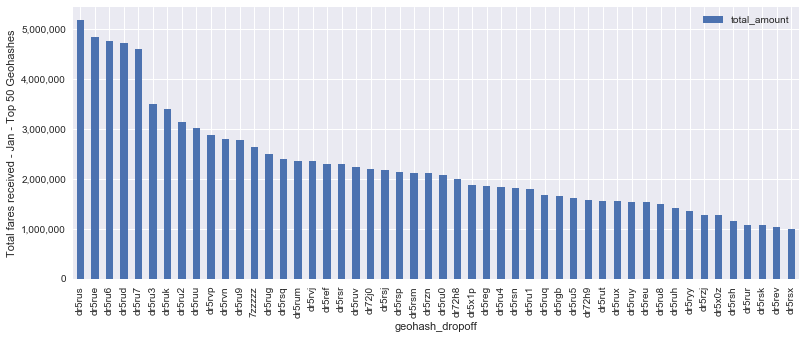

In [55]:
#plt.figure(figsize=(10,5))
ax = dropoff_sum_fare[:50].plot(x='geohash_dropoff',y='total_amount',kind='bar',figsize=(13,5))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel('Total fares received - Jan - Top 50 Geohashes')

# Use an Actor Critic MOdel
- https://yanpanlau.github.io/2016/10/11/Torcs-Keras.html

In [ ]:
def create_actor_network(self, state_size,action_dim):
        print("Now we build the model")
        S = Input(shape=[state_size])  
        h0 = Dense(HIDDEN1_UNITS, activation='relu')(S)
        h1 = Dense(HIDDEN2_UNITS, activation='relu')(h0)
        Steering = Dense(1,activation='tanh',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        Acceleration = Dense(1,activation='sigmoid',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        Brake = Dense(1,activation='sigmoid',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        V = merge([Steering,Acceleration,Brake],mode='concat')          
        model = Model(input=S,output=V)
        print("We finished building the model")
        return model, model.trainable_weights, S